# Keypoint Estimation

Michael Fatemi, December 2023

This is Part 2 of onboarding with the UVA Collaborative Robotics Lab. Predicting raw actions with machine learning results in a target that is too noisy and complicated. We would rather have our model operate on a more abstract level, and let low-level planning be executed by performant algorithms. We see high success in increased levels of abstraction in the planning process in terms of training speed, sample efficiency, and success rates, as demonstrated by the PerAct and RVT papers.

In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
!echo $LD_LIBRARY_PATH

/home/gsk6me/lib/CoppeliaSim_Edu_V4_1_0_Ubuntu16_04:/scratch/gsk6me/CoppeliaSim_Edu_V4_1_0_Ubuntu16_04:/scratch/gsk6me//home/gsk6me/CollabRobotics/CoppeliaSim_Edu_V4_1_0_Ubuntu16_04:/opt/slurm/current/lib:/share/rci_apps/common/lib64:


In [3]:
import numpy as np
from rlbench.action_modes.action_mode import MoveArmThenGripper
from rlbench.action_modes.arm_action_modes import JointVelocity
from rlbench.action_modes.gripper_action_modes import Discrete
from rlbench.environment import Environment
from rlbench.tasks import OpenDrawer
from rlbench.observation_config import ObservationConfig

import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

## Loading Demonstration Data

I have downloaded the `open_drawer` task from the set of pregenerated data provided by the `peract` repository.

In [4]:
# Get some observations
env = Environment(
    MoveArmThenGripper(arm_action_mode=JointVelocity(), gripper_action_mode=Discrete()),
    '/scratch/gsk6me/RLBench_Data/train',
    obs_config=ObservationConfig(),
    headless=True)
env.launch()

task = env.get_task(OpenDrawer)

print("Getting demos...")
demos = task.get_demos(8, live_demos=False)

env.shutdown()

Getting demos...


In [5]:
len(demos)

8

## Getting Object Representations with Segment Anything

Fortunately, Segment Anything is on HuggingFace.

In [4]:
from PIL import Image
import requests
from transformers import SamModel, SamProcessor
from transformers import pipeline

generator =  pipeline("mask-generation", model='facebook/sam-vit-base', device=0, points_per_batch=256)
image_url = "https://huggingface.co/ybelkada/segment-anything/resolve/main/assets/car.png"
outputs = generator(image_url, points_per_batch = 256)

# model = SamModel.from_pretrained("facebook/sam-vit-base").to("cuda")
# processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# img_url = "https://huggingface.co/ybelkada/segment-anything/resolve/main/assets/car.png"
# input_points = [[[450, 600]]] # 2D localization of a window

# inputs = processor(raw_image, input_points=input_points, return_tensors="pt").to("cuda")
# outputs = model(**inputs)
# masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())
# scores = outputs.iou_scores


2023-12-20 03:16:13.026867: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-20 03:16:13.070857: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-20 03:16:14.664944: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[CoppeliaSim:loadinfo]   done.


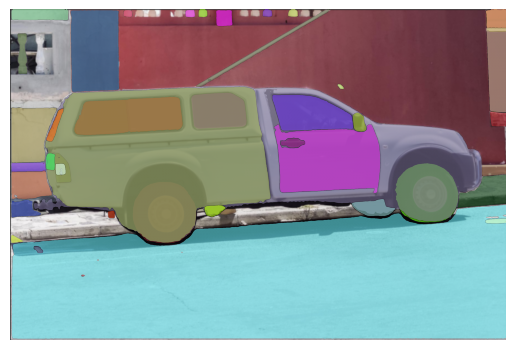

In [5]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
raw_image = Image.open(requests.get(image_url, stream=True).raw).convert("RGB")
plt.imshow(np.array(raw_image))
ax = plt.gca()
for mask in outputs["masks"]:
    show_mask(mask, ax=ax, random_color=True)
plt.axis("off")
plt.show()


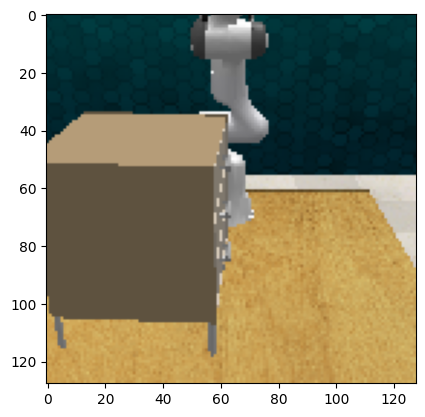

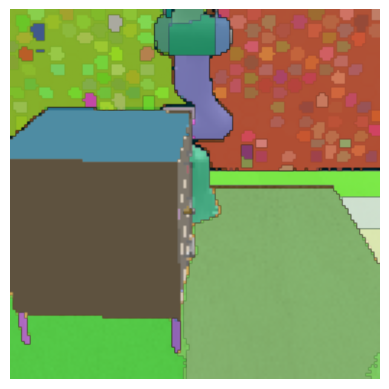

In [6]:
# Testing Segment Anything with demo images

raw_image = demos[0][0].front_rgb

plt.imshow(raw_image)
plt.show()

pil_image = Image.fromarray(raw_image)
outputs = generator(pil_image, points_per_batch = 256)
plt.imshow(raw_image)
ax = plt.gca()
for mask in outputs["masks"]:
    show_mask(mask, ax=ax, random_color=True)
plt.axis("off")
plt.show()

In [ ]:
# Incorporate with Vision/Language models (maybe a vision model that does semantic segmentation)?
# - try to get zero shot or etc. for these foundation models
# - manipulation: can be grasping, pushing, etc.


# need to ground the VLM in robot space
# then, predicting keypoints
# use more data when possible

# could try a learning rate schedule


## Cleaning Up This Image

To clean up this image, I will use the 3D rendering techniques used in RVT. I essentially will use the RGB-D information to construct a point cloud and voxelize this point cloud to allow the creation of synthetic views.


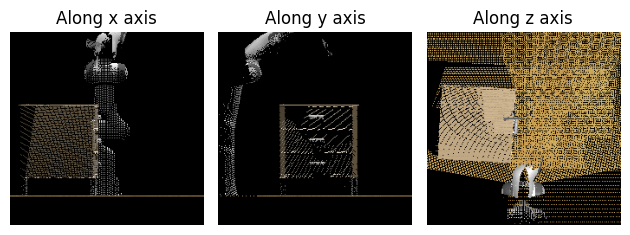

In [7]:
from voxel_renderer import VoxelRenderer
import cv2
import matplotlib.pyplot as plt

device = 'cuda'

SCENE_BOUNDS = [
    -0.3,
    -0.5,
    0.6,
    0.7,
    0.5,
    1.6,
]
VOXEL_IMAGE_SIZE = 224
BACKGROUND_COLOR = torch.tensor([0, 0, 0], device=device)

renderer = VoxelRenderer(SCENE_BOUNDS, VOXEL_IMAGE_SIZE, BACKGROUND_COLOR, device=device)

obs = demos[0][0]

pcds = []
colors = []

cameras = [
    'front',
    'left_shoulder',
    'right_shoulder',
    'wrist',
]

for camera in cameras:
    pcds.append(
        torch.tensor(getattr(obs, camera + '_point_cloud').reshape(-1, 3))
    )
    colors.append(
        torch.tensor(getattr(obs, camera + '_rgb').reshape(-1, 3) / 255.0)
    )

pcd = torch.cat(pcds).to(device)
color = torch.cat(colors).to(device)
images = renderer(pcd, color)

plt.clf()
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title("Along " + ('xyz'[i]) + " axis")
    # Blur the image slightly
    raw_image = (images[i].cpu().numpy()).astype(np.float32)
    # image_blurred = cv2.bilateralFilter(raw_image, 5, 75, 75)
    plt.imshow(raw_image, origin='lower')
    plt.axis('off')
plt.tight_layout()
plt.show()


## Keypoint Extraction

Here, we reuse some code from the PerAct notebook to extract keypoints. These will become our prediction targets.

In [8]:
# From https://github.com/stepjam/ARM/blob/main/arm/demo_loading_utils.py

from rlbench.demo import Demo
from typing import List

def _is_stopped(demo, i, obs, stopped_buffer, delta=0.1):
    next_is_not_final = i == (len(demo) - 2)
    gripper_state_no_change = (
            i < (len(demo) - 2) and
            (obs.gripper_open == demo[i + 1].gripper_open and
             obs.gripper_open == demo[i - 1].gripper_open and
             demo[i - 2].gripper_open == demo[i - 1].gripper_open))
    small_delta = np.allclose(obs.joint_velocities, 0, atol=delta)
    stopped = (stopped_buffer <= 0 and small_delta and
               (not next_is_not_final) and gripper_state_no_change)
    return stopped

def _keypoint_discovery(demo: Demo,
                        stopping_delta=0.1) -> List[int]:
    episode_keypoints = []
    prev_gripper_open = demo[0].gripper_open
    stopped_buffer = 0
    for i, obs in enumerate(demo):
        stopped = _is_stopped(demo, i, obs, stopped_buffer, stopping_delta)
        stopped_buffer = 4 if stopped else stopped_buffer - 1
        # if change in gripper, or end of episode.
        last = i == (len(demo) - 1)
        if i != 0 and (obs.gripper_open != prev_gripper_open or
                        last or stopped):
            episode_keypoints.append(i)
        prev_gripper_open = obs.gripper_open
    if len(episode_keypoints) > 1 and (episode_keypoints[-1] - 1) == \
            episode_keypoints[-2]:
        episode_keypoints.pop(-2)
    print('Found %d keypoints.' % len(episode_keypoints), episode_keypoints)
    return episode_keypoints

### Testing Keypoint Estimation

Let's see what positions the algorithm has selected as keypoints.

Found 3 keypoints. [68, 81, 104]


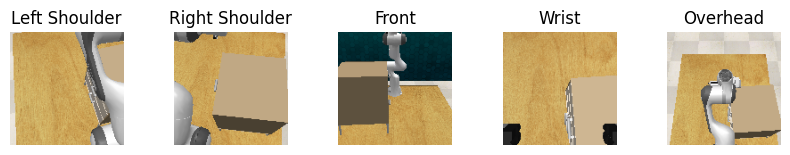

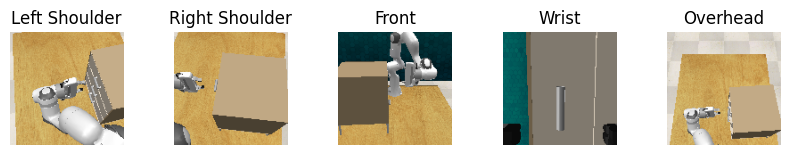

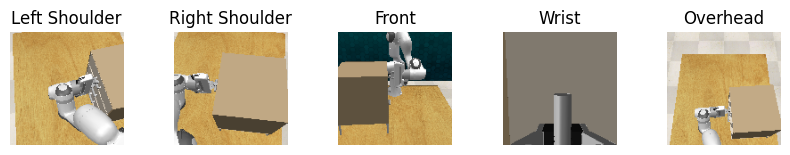

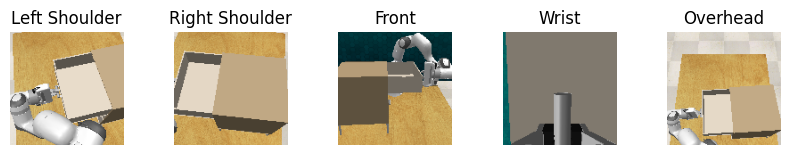

In [9]:
import matplotlib.pyplot as plt

def plot_keypoints(demo):
    keypoints = _keypoint_discovery(demo)
    
    plt.rcParams['figure.figsize'] = (8, 6)
    
    for keypoint in [0, *keypoints]:
        obs = demo[keypoint]
        # Available views:
        # ['front_rgb', 'left_shoulder_rgb', 'overhead_rgb', 'right_shoulder_rgb', 'wrist_rgb']
        # Let's plot the left and right shoulders.
        for i, view in enumerate(['left_shoulder_rgb', 'right_shoulder_rgb', 'front_rgb', 'wrist_rgb', 'overhead_rgb']):
            plt.subplot(1, 5, i + 1)
            plt.title(" ".join(view.split("_")[:-1]).title())
            plt.imshow(getattr(obs, view))
            plt.tight_layout()
            plt.axis('off')
            
        plt.show()

plot_keypoints(demos[0])

## Keypoint Prediction

Our next step is to predict keypoint locations. We may be able to do this by treating this as an image segmentation task. We can take the position of the arm and project it to the vision sensors used to generate the observation.

In [12]:
env = Environment(
    MoveArmThenGripper(arm_action_mode=JointVelocity(), gripper_action_mode=Discrete()),
    '/scratch/gsk6me/RLBench_Data/train',
    obs_config=ObservationConfig(),
    headless=True)
env.launch()

intrinsics = [
    env._scene._cam_front.get_intrinsic_matrix(),
    env._scene._cam_wrist.get_intrinsic_matrix(),
    env._scene._cam_overhead.get_intrinsic_matrix(),
    env._scene._cam_over_shoulder_left.get_intrinsic_matrix(),
    env._scene._cam_over_shoulder_right.get_intrinsic_matrix()
]

extrinsics = [
    env._scene._cam_front.get_matrix(),
    env._scene._cam_wrist.get_matrix(),
    env._scene._cam_overhead.get_matrix(),
    env._scene._cam_over_shoulder_left.get_matrix(),
    env._scene._cam_over_shoulder_right.get_matrix()
]

env.shutdown()

[CoppeliaSim:loadinfo]   done.


### Plotting position on images

We will use these matrices to plot robot joint position.

Found 3 keypoints. [68, 81, 104]


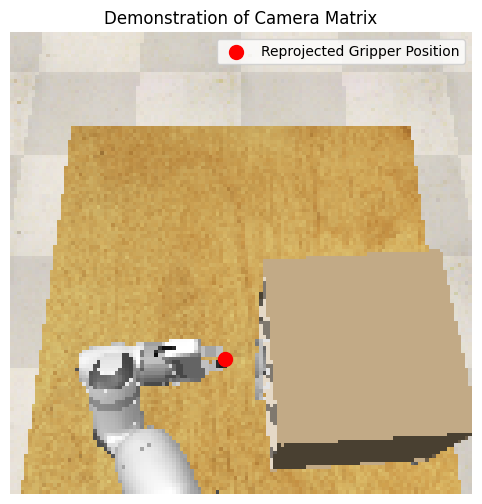

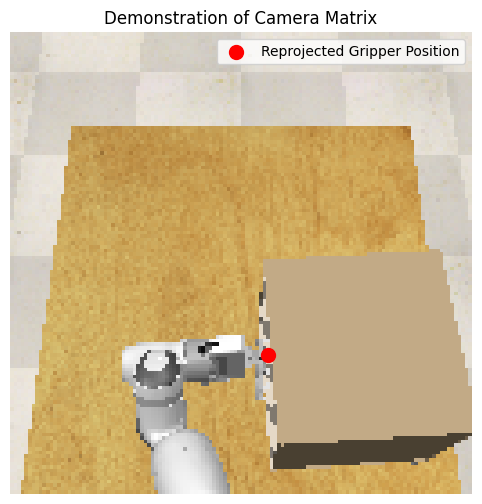

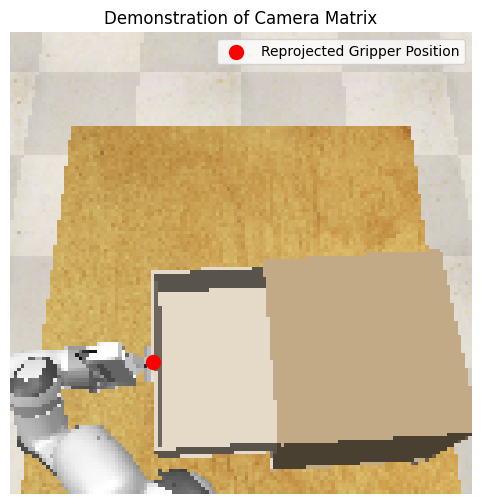

In [13]:
def get_camera_projection_matrix(intrinsics, extrinsics):
    C = np.expand_dims(extrinsics[:3, 3], 0).T
    R = extrinsics[:3, :3]
    R_inv = R.T  # inverse of rot matrix is transpose
    R_inv_C = np.matmul(R_inv, C)
    extrinsics = np.concatenate((R_inv, -R_inv_C), -1)
    cam_proj_mat = np.matmul(intrinsics, extrinsics)
    return cam_proj_mat
    
# matrix: [R t]

def gripper_pose_to_pixel(pos, camera_matrix):
    pos_pad = np.array([*pos[:3], 1])
    pixel = camera_matrix @ pos_pad
    pixel = pixel / pixel[2]
    pixel = pixel[:-1]
    x = int(pixel[0])
    y = int(pixel[1])
    return x, y

def plot_demo_keypoints(demo, camera_matrix):
    keypoints = _keypoint_discovery(demo)

    for keypoint in keypoints:
        obs = demo[keypoint]
        # [x, y, z, quat]
        x, y = gripper_pose_to_pixel(obs.gripper_pose, camera_matrix)
        
        # Draw box
        image = obs.overhead_rgb
        plt.imshow(image)
        plt.scatter(x, y, marker='o', s=100, c='red', label="Reprojected Gripper Position")
        plt.title("Demonstration of Camera Matrix")
        plt.legend()
        plt.axis('off')
        plt.show()

camera_index = 2
M = get_camera_projection_matrix(intrinsics[camera_index], extrinsics[camera_index])
demo = demos[0]

plot_demo_keypoints(demo, M)

## Supervised Training and Dataset Creation

Now, it is time for us to create a dataset. We have reduced our problem to that of image segmentation. I will just use a U-net I found online for this.

In [13]:
import torchvision.transforms.functional as TF
from unet import UNet
model = UNet(n_channels=3, n_classes=2)
test_input = TF.to_tensor(obs.overhead_rgb)
model(test_input[None, ...]).shape, test_input.shape # (b, c, h, w)

(torch.Size([1, 2, 128, 128]), torch.Size([3, 128, 128]))

In [14]:
from transformers import CLIPImageProcessor, CLIPVisionModel, CLIPModel, CLIPTokenizerFast

device = 'cuda'
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_vision_model = CLIPVisionModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_image_processor = CLIPImageProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_text_tokenizer = CLIPTokenizerFast.from_pretrained("openai/clip-vit-base-patch32")


2024-01-17 00:47:05.075783: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-17 00:47:05.264306: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-17 00:47:10.279748: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/568 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

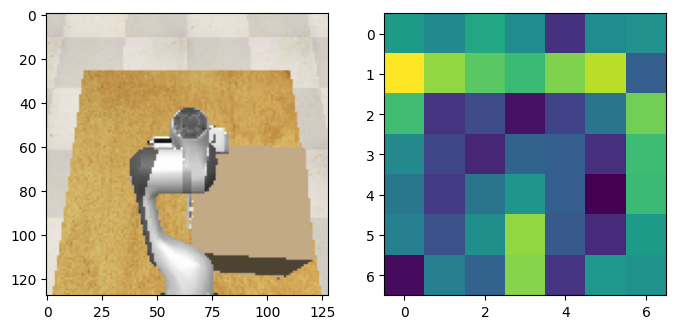

In [15]:
with torch.no_grad():
    output = clip_vision_model(**clip_image_processor(demos[0][0].overhead_rgb, return_tensors='pt').to('cuda'))
# output.last_hidden_state.shape: 1, 50, 768
# Reshape this to (7, 7)
# Class embedding is first.
# See CLIPVisionEmbeddings in https://github.com/huggingface/transformers/blob/main/src/transformers/models/clip/modeling_clip.py.
# Patch embeddings are a Conv2D that outputs (num_channels, 7, 7) -> (num_channels, 49) -> (49, num_channels) [the tokens]
# (7, 7) because this is a ViT-32/b, which has 32x32 px tokens (and for 224x224 input images, there are 7 tokens per dimension)
result = output.last_hidden_state[0, 1:, :].mean(dim=-1).reshape(7, 7)
plt.subplot(1, 2, 1)
plt.imshow(demos[0][0].overhead_rgb)
plt.subplot(1, 2, 2)
plt.imshow(result.cpu().numpy())
plt.show()
# We will now use these embeddings to predict a logit score.

In [16]:
# Now, we create our dataset
# We reuse M, our camera projection matrix from before.

import torchvision.transforms.functional as TF

device = 'cuda'

def create_dataset(demos):
    buffer = []
    for demo in demos:
        keypoints = _keypoint_discovery(demo)
        print([0, *keypoints]) # the last point of the demo is automatically used as a keypoint so we do not add it
        
        for i in range(len(demo) - 1):
            next_keypoint = None
            for keypoint in keypoints:
                if keypoint > i:
                    next_keypoint = keypoint
                    break

            # Target
            x, y = gripper_pose_to_pixel(demo[next_keypoint].gripper_pose, M) # [x, y, z, quat]
            # Use camera matrix to convert 3D position to pixel location.
            # Normalize by the 3rd coordinate (common practice) and then remove it.
            # pos_pad = np.array([*pos[:3], 1])
            # pixel = (M @ pos_pad)
            # pixel = pixel / pixel[2]
            # pixel = pixel[:-1]
            # # Convert to integers.
            # x = int(pixel[0] / 128 * 7)
            # y = int(pixel[1] / 128 * 7)
            # Create target image.
            target_image = np.zeros((1, 7, 7), dtype=np.float32)
            # Use Gaussian PDF as target: https://en.wikipedia.org/wiki/Multivariate_normal_distribution
            # Assumes a diagonal covariance matrix, with entries of 1/period.
            # Inverse of diagonal => Diagonal with reciprocals as entries.
            # Determinant of diagonal matrix => Product of diagonal entries.
            # period = 1
            # xv, yv = np.meshgrid(np.arange(0, 7), np.arange(0, 7))
            # numer = np.exp(-1/2 * ((xv - x) ** 2 + (yv - y) ** 2) * period)
            # denom = (2 * np.pi * (1/period)) # np.sqrt((2 * pi) ** k * (period ** k)); k = 2
            # target_image[0, xv, yv] = numer/denom
            target_image[0, int(y / 128 * 7), int(x / 128 * 7)] = 1
            buffer.append(
                (TF.to_tensor(demo[i].overhead_rgb).to(device), torch.tensor(target_image, device=device), (x, y))
            )
    return buffer

buffer = create_dataset(demos[:-2])

Found 3 keypoints. [68, 81, 104]
[0, 68, 81, 104]
Found 3 keypoints. [58, 71, 96]
[0, 58, 71, 96]
Found 3 keypoints. [67, 82, 115]
[0, 67, 82, 115]
Found 3 keypoints. [57, 70, 96]
[0, 57, 70, 96]
Found 3 keypoints. [65, 79, 107]
[0, 65, 79, 107]
Found 3 keypoints. [72, 87, 125]
[0, 72, 87, 125]


In [19]:
device = 'cuda'

cameras = [
    'front',
    'left_shoulder',
    'right_shoulder',
    'wrist',
]

SCENE_BOUNDS = [
    -0.3,
    -0.5,
    0.6,
    0.7,
    0.5,
    1.6,
]
VOXEL_IMAGE_SIZE = 224
BACKGROUND_COLOR = torch.tensor([0, 0, 0], device=device)

renderer = VoxelRenderer(SCENE_BOUNDS, VOXEL_IMAGE_SIZE, BACKGROUND_COLOR, device=device)

def create_dataset_with_voxelizer(demos):
    buffer = []
    for demo in demos:
        keypoints = _keypoint_discovery(demo)
        print([0, *keypoints]) # the last point of the demo is automatically used as a keypoint so we do not add it
        
        for i in range(len(demo) - 1):
            next_keypoint = None
            for keypoint in keypoints:
                if keypoint > i:
                    next_keypoint = keypoint
                    break

            # Only process images for keypoint frames
            if i != 0 and (i - 1) not in keypoints:
                continue

            obs = demo[i]

            # Target
            x, y, z, *_quat = demo[next_keypoint].gripper_pose
            x, y, z = renderer._discretize_point(torch.tensor([x, y, z], device=device))

            pcds = []
            colors = []
            
            for camera in cameras:
                pcds.append(
                    torch.tensor(getattr(obs, camera + '_point_cloud').reshape(-1, 3))
                )
                colors.append(
                    torch.tensor(getattr(obs, camera + '_rgb').reshape(-1, 3) / 255.0)
                )

            pcd = torch.cat(pcds).to(device)
            color = torch.cat(colors).to(device)
            zy_image, zx_image, xy_image = renderer(pcd, color)
            
            # Create target images
            target_images = torch.zeros((3, 7, 7), dtype=torch.int)
            target_images[0, int(z/32), int(y/32)] = 1
            target_images[1, int(z/32), int(x/32)] = 1
            target_images[2, int(x/32), int(y/32)] = 1
            
            buffer.append((
                zy_image.permute(2, 0, 1), target_images[0],
                zx_image.permute(2, 0, 1), target_images[1],
                xy_image.permute(2, 0, 1), target_images[2],
            ))
    return buffer

In [20]:
train_dataset = create_dataset_with_voxelizer(demos[:-2])

Found 3 keypoints. [68, 81, 104]
[0, 68, 81, 104]
Found 3 keypoints. [58, 71, 96]
[0, 58, 71, 96]
Found 3 keypoints. [67, 82, 115]
[0, 67, 82, 115]
Found 3 keypoints. [57, 70, 96]
[0, 57, 70, 96]
Found 3 keypoints. [65, 79, 107]
[0, 65, 79, 107]
Found 3 keypoints. [72, 87, 125]
[0, 72, 87, 125]


In [58]:
from mvt_mine import MVT
from noamopt import NoamOpt

model = MVT().to(device)

optim = torch.optim.Adam(model.parameters(), lr=1e-6, betas=(0.9, 0.98), eps=1e-9)
# lr_scheduler = NoamOpt(model.dim, factor=2, warmup=200, optimizer=optim)
lr_scheduler = None

dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

for epoch in range(2000):
    # {zy, zx, xy}i: input images
    # {...}o: target images
    # {...}p: model predictions
    for (zyi, zyo, zxi, zxo, xyi, xyo) in dataloader: # tqdm.tqdm(dataloader, desc='Training epoch ' + str(epoch)):
        # print(zyi.shape, zxi.shape, xyi.shape)
        out = model(torch.stack([zyi, zxi, xyi], dim=1).float())
        zyp, zxp, xyp = out.permute(1, 0, 2, 3, 4)
        # Combine predictions when making loss
        pred = torch.cat([
            zyp.reshape(-1, 49),
            zxp.reshape(-1, 49),
            xyp.reshape(-1, 49)
        ], dim=-1)
        target = torch.cat([
            zyo.reshape(-1, 49),
            zxo.reshape(-1, 49),
            xyo.reshape(-1, 49),
        ], dim=-1).to(device).float()
        # print(pred.shape, target.shape)
        loss = F.cross_entropy(pred, target)
        loss.backward()
        optim.step()
        if lr_scheduler is not None:
            lr_scheduler.step()
    
    print(f"{epoch + 1:4} {loss.item():.3f}", end='\r')
    if (epoch + 1) % 100 == 0:
        print()


 100 12.381
 200 10.104
 300 9.1515
 400 8.125
 500 7.519
 600 7.223
 700 6.772
 800 6.251
 900 6.120
1000 5.834
1100 5.399
1200 5.252
1300 4.678
1400 4.742
1500 4.364
1600 4.156
1700 4.134
1800 4.003
1900 4.007
2000 3.845


In [32]:
# Now, plot the predicted keypoints on a validation set.
valid_buffer = create_dataset_with_voxelizer(demos[-2:])

Found 3 keypoints. [59, 73, 101]
[0, 59, 73, 101]
Found 3 keypoints. [59, 72, 98]
[0, 59, 72, 98]


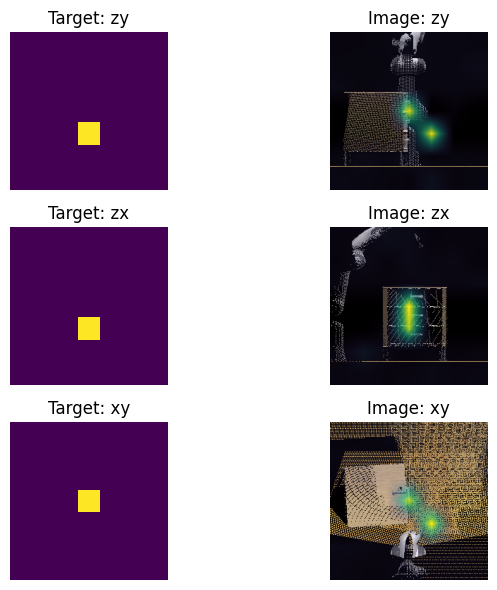

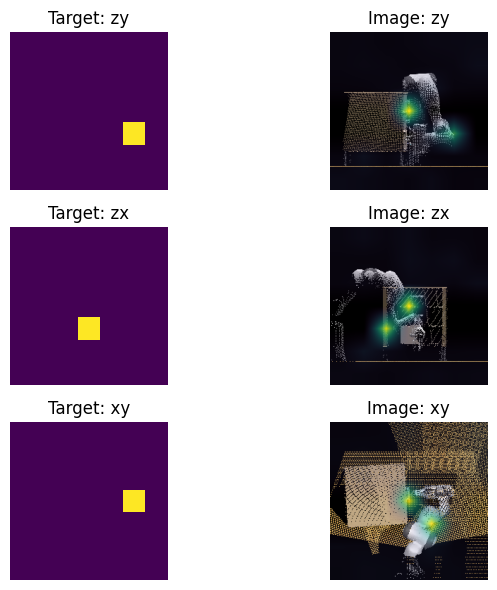

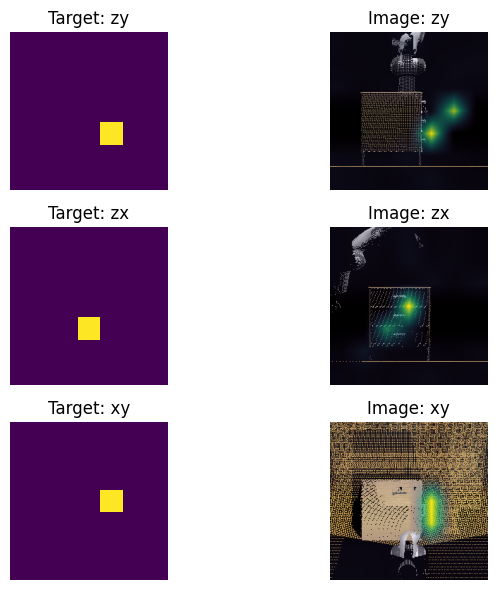

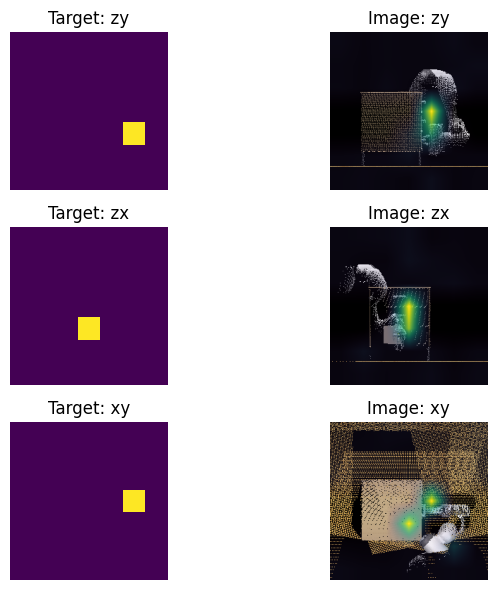

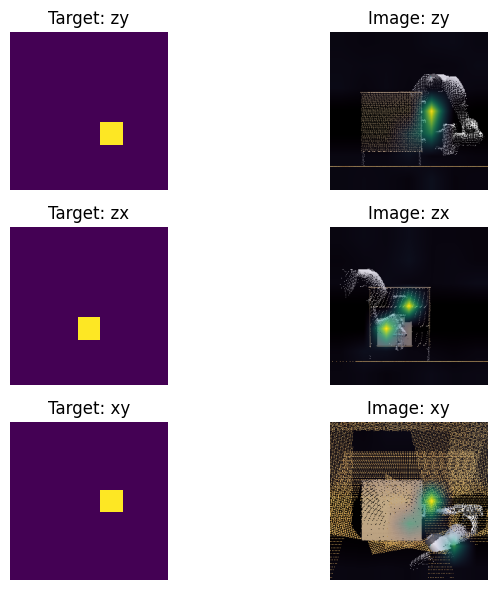

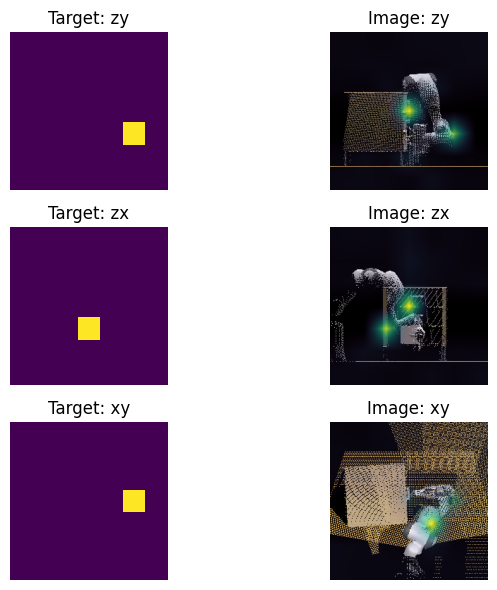

In [65]:
# Choose random indices
for index in np.random.randint(len(valid_buffer), size=6):
    (zyi, zyo, zxi, zxo, xyi, xyo) = valid_buffer[index]

    with torch.no_grad():
        out = model(torch.stack([zyi, zxi, xyi], dim=0)[None].float())
        zyp, zxp, xyp = out.permute(1, 0, 2, 3, 4)
    
    # {zy, zx, xy}s: softmax'd result
    zys = zyp[..., 0].softmax(-1).reshape(-1, 7, 7)
    zxs = zxp[..., 0].softmax(-1).reshape(-1, 7, 7)
    xys = xyp[..., 0].softmax(-1).reshape(-1, 7, 7)

    for i, (heatmap, target, img) in enumerate((
        (zys, zyo, zyi),
        (zxs, zxo, zxi),
        (xys, xyo, xyi),
    )):
        label = ('zy', 'zx', 'xy')[i]

        heatmap = heatmap[0].cpu().numpy()

        # print(heatmap.max(), heatmap.min(), heatmap)

        # plt.subplot(3, 3, i * 3 + 1)
        # plt.title("Heatmap: " + label)
        # plt.imshow(heatmap[0].cpu().numpy(), origin='lower')
        # plt.axis('off')
    
        plt.subplot(3, 2, i * 2 + 1)
        plt.title("Target: " + label)
        plt.imshow(target.cpu().numpy(), origin='lower')
        plt.axis('off')
        
        plt.subplot(3, 2, i * 2 + 2)
        plt.title("Image: " + label)
        plt.imshow(img.cpu().permute(1, 2, 0).numpy(), origin='lower')
        # resize heatmap
        heatmap = cv2.resize(heatmap, (224, 224))
        plt.imshow(heatmap, origin='lower', alpha=heatmap)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

Found 3 keypoints. [62, 76, 101]
[0, 62, 76, 101]
Found 3 keypoints. [62, 75, 104]
[0, 62, 75, 104]


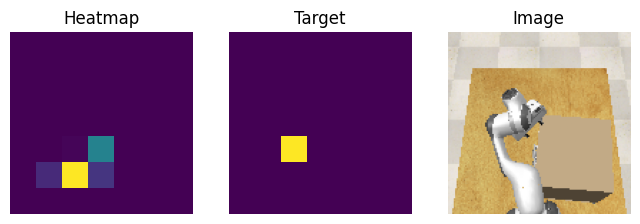

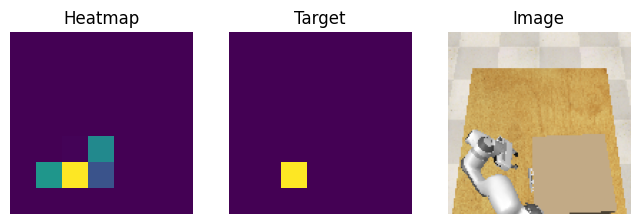

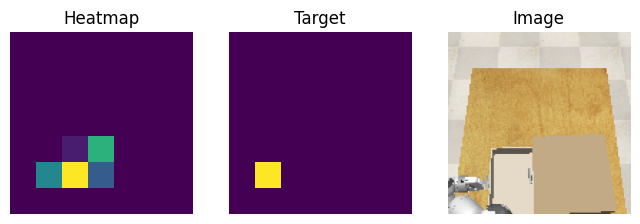

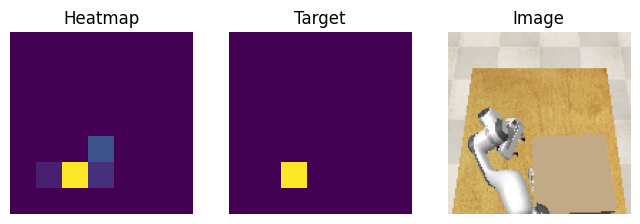

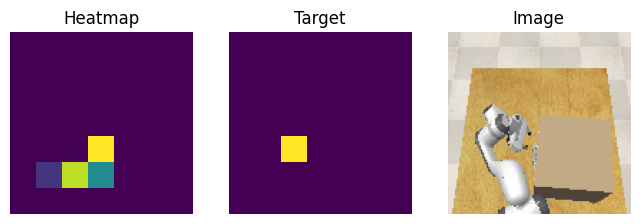

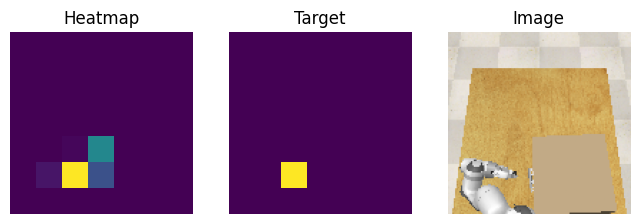

In [188]:
# Now, plot the predicted keypoints on a validation set.
valid_buffer = create_dataset(demos[-2:])

# Choose random indices

for index in np.random.randint(len(valid_buffer), size=6):
    img, target, (x, y) = valid_buffer[index]
    
    prepared_inputs = clip_image_processor([img], return_tensors='pt').to(device)
    clip_output = model(**prepared_inputs)
    # Remove the [cls] token and create heatmap from remaining ViT tokens
    heatmaps = mlp(clip_output.last_hidden_state[:, 1:])[:, :, 0]
    
    weights = heatmaps.softmax(-1).reshape(-1, 7, 7)[0].detach().cpu().numpy()
    weights = weights / weights.max()
    
    # plt.imshow(demos[0][index].overhead_rgb)
    plt.subplot(1, 3, 1)
    plt.title("Heatmap")
    plt.imshow(weights)
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.title("Target")
    plt.imshow(target[0].cpu().numpy())
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.title("Image")
    plt.imshow(img.cpu().permute(1, 2, 0).numpy())
    plt.axis('off')
    plt.show()